# CH05.1. **Generative Adversarial Networks**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 2
EPOCH_NUM = 100
USE_CHECKPOINT_YN = 'N'
MODEL_PTH = '../../model/mnistFashionGAN.pt'
LOGGER_PTH = '../../log/mnistFashionTrainLogger.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import ipywidgets
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torchvision
import torchinfo

#(2) Set up options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Set up device
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

#(4) Set up HTML tag
display(ipywidgets.HTML(data=
'''
<style> 
    .white-play button {
        background-color: white !important; 
        color: black !important;
    } 
</style>
'''
))

>> Device : mps


HTML(value='')

#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `show_img` function
def show_img(df:torchvision.datasets, index:int) -> plt.figure :
    img = df[index][0]
    target = df[index][1]
    img = (img/2+0.5).numpy() # -1 ~ 1 normalization 
    channel_cnt = img.shape[0]
    if channel_cnt == 3 :
        img = np.transpose(a=img, axes=(1, 2, 0))
        plt.imshow(X=img) 
    elif channel_cnt == 1 : 
        img = np.squeeze(a=img, axis=0)
        plt.imshow(X=img, cmap='gray')
    else : 
        pass 
    plt.xlabel(xlabel=f'Target : {target}({df.classes[target]})')
    plt.show()

#(2) Define 

#### 00.3. **클래스 정의**

In [4]:
#(1) Create `Generator` class
class Generator(torch.nn.Module) :
    def __init__(self, input_shape:list, latent_dim:int, device:torch.device) :
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = input_shape[1] * input_shape[2]
        self.device = device
        self.linear_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.latent_dim, out_features=256),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Linear(in_features=256, out_features=512),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Linear(in_features=512, out_features=1024),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Linear(in_features=1024, out_features=self.output_dim),
            torch.nn.Tanh()
        )
        self.to(device=device)
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        x = x.to(device=self.device)
        x = self.linear_block(x)
        x = x.reshape(shape=(-1, 1, 28, 28))
        return x

#(2) Create `Discriminator` class
class Discriminator(torch.nn.Module):
    def __init__(self, input_shape:list, device:torch.device) :
        super().__init__()
        self.input_dim = input_shape[1] * input_shape[2]
        self.device = device
        self.linear_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.input_dim, out_features=1024),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=512, out_features=256),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(in_features=256, out_features=1), 
            torch.nn.Sigmoid()
        )
        self.to(device=device)
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        x = x.to(device=self.device)
        x = x.reshape(shape=(-1, 784))
        x = self.linear_block(x)
        return x 
    
#(3) Define `TrainLogger` class
class TrainLogger : 
    def __init__(self) :
        self.train_log = {
            'epoch'       : [],
            'inputs_real' : [],
            'preds_real'  : [],
            'preds_fake'  : []
        }
    def log(self, epoch:int, inputs:torch.Tensor, preds:torch.Tensor, path:str) :
        self.train_log['epoch'].append(epoch)
        self.train_log['inputs_real'].append(inputs)
        self.train_log['preds_real'].append(preds)
        self.train_log['preds_fake'].append(preds)
        torch.save(obj={'train_log':self.train_log}, f=path)
    def move_device(self, device:str) :
        for i in range(len(self.train_log['inputs'])) :
            if (device == 'cpu') :
                self.train_log['inputs_real'][i] = self.train_log['inputs_real'][i].detach().cpu().numpy()
                self.train_log['preds_real'][i] = self.train_log['preds_real'][i].detach().cpu().numpy()
                self.train_log['preds_fake'][i] = self.train_log['preds_fake'][i].detach().cpu().numpy()
            else :
                self.train_log['inputs_real'][i] = self.train_log['inputs_real'][i].to(device=device)
                self.train_log['preds_real'][i] = self.train_log['preds_real'][i].to(device=device)
                self.train_log['preds_fake'][i] = self.train_log['preds_fake'][i].to(device=device)

#(4) Define `Visualizer` class
class Visualizer :    
    def __init__(self, train_log:dict, fig_size:tuple=(8, 8)) :
        self.train_log = train_log
        self.fig_size = fig_size
        self.epoch_min = min(self.train_log['epoch'])
        self.epoch_max = max(self.train_log['epoch'])
        self.epoch_num = len(train_log['epoch']) - 1
        self.sample_num = train_log['inputs_real'][0].shape[0] - 1
        self.widget_output = ipywidgets.Output(
            layout=ipywidgets.Layout(
                width='auto', 
                height='auto', 
                margin='0px', 
                padding='0px'
            )
        )
        self.epoch_play = ipywidgets.Play(
            min=self.epoch_min,
            max=self.epoch_max,
            step=1,
            value=0,
            interval=250,
            description='Epoch Play',
            disabled=False
        )
        self.epoch_play.add_class(className='white-play')
        self.epoch_slider = ipywidgets.IntSlider(
            min=self.epoch_min,
            max=self.epoch_max,
            step=1,
            value=0,
            description='Epoch',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self.sample_slider = ipywidgets.IntSlider(
            min=0,
            max=self.sample_num,
            step=1,
            value=0,
            description='Sample',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        ipywidgets.jslink(attr1=(self.epoch_play, 'value'), attr2=(self.epoch_slider, 'value'))
        self.epoch_slider.observe(handler=self.on_epoch_change, names='value')
        self.sample_slider.observe(handler=self.on_sample_change, names='value')
        with self.widget_output:
            self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(nrows=1, ncols=3, figsize=self.fig_size)
            try:
                self.fig.canvas.header_visible = False
                self.fig.canvas.toolbar_visible = False
            except:
                pass
            plt.show()
        self.update_view()
    def on_epoch_change(self, change:dict) :
        self.update_view()
    def on_sample_change(self, change:dict) :
        self.update_view()
    def update_view(self) :
        with self.widget_output:
            self.ax1.clear()
            self.ax2.clear()
            ep_value = self.epoch_slider.value
            ep_idx = self.train_log['epoch'].index(ep_value)
            sp_idx = self.sample_slider.value
            input_real_img = self.train_log['inputs_real'][ep_idx][sp_idx].squeeze()
            pred_real_img = self.train_log['preds_real'][ep_idx][sp_idx].squeeze()
            pred_fake_img = self.train_log['preds_fake'][ep_idx][sp_idx].squeeze()
            self.ax1.imshow(X=input_real_img, cmap='gray')
            self.ax1.set_title(label='Target', fontdict={'fontsize': 12})
            self.ax1.set_aspect(aspect='auto')
            self.ax1.axis('off')
            self.ax2.imshow(X=pred_real_img, cmap='gray')
            self.ax2.set_title(label='Prediction (Real)', fontdict={'fontsize': 12})
            self.ax2.set_aspect(aspect='auto')
            self.ax2.axis('off')
            self.ax3.imshow(X=pred_fake_img, cmap='gray')
            self.ax3.set_title(label='Prediction (Fake)', fontdict={'fontsize': 12})
            self.ax3.set_aspect(aspect='auto')
            self.ax3.axis('off')
            self.fig.canvas.draw_idle()
    def plot_compare(self) -> ipywidgets.widgets :
        controls_box = ipywidgets.VBox(
            children=[
                self.epoch_slider,
                self.sample_slider,
                self.epoch_play
            ],
            layout=ipywidgets.Layout(
                align_items='center',
                margin='0% 0% 15% -5%'
            )
        )
        ui = ipywidgets.HBox(
            children=[self.widget_output, controls_box],
            layout=ipywidgets.Layout(
                justify_content='flex-start',
                align_items='center',
                width='auto',
                margin='0px',
                padding='0px'
            )
        )
        display(ui)

<b></b>

## 01. **데이터셋 전처리 및 로드**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
    ]
)

#### 01.2. **데이터셋 로드**

In [6]:
mnist_train = torchvision.datasets.FashionMNIST(root='../../data', train=True, download=True, transform=img_tf)
mnist_test = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
len(mnist_train)

60000

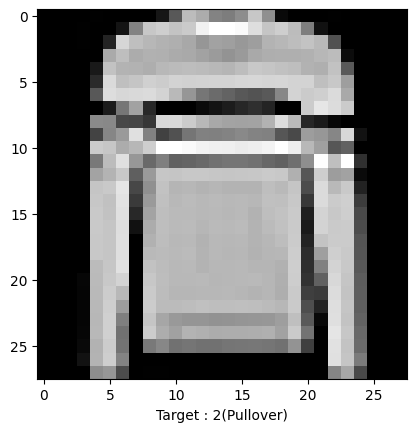

In [8]:
#(2) Display image
show_img(df=mnist_train, index=5)

In [9]:
#(3) Check `input_size`
input_shape = list(mnist_train[0][0].shape)

#(4) Print `input_size`
input_shape

[1, 28, 28]

In [10]:
#(5) Print frequency of target class
target_freq = collections.Counter()
for i in range(len(mnist_train)):
    input, target = mnist_train[i]
    if isinstance(target, torch.Tensor) :
        target = target.item()
    target_freq[target] += 1
pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

,class,count
1,0,6000
6,1,6000
3,2,6000
2,3,6000
8,4,6000
5,5,6000
7,6,6000
4,7,6000
9,8,6000
0,9,6000


#### 01.4. **데이터로더 변환**

In [11]:
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 02. **모델 구축 및 학습**

#### 02.1. **하이퍼 파라미터 정의**

In [12]:
latent_dim = 128

#### 02.2.1. **Generator 모델 정의**

In [13]:
#(1) Define `gen_model`
gen_model = Generator(input_shape=input_shape, latent_dim=latent_dim, device=device)

#(2) Display `gen_model`
torchinfo.summary(
    model=gen_model, 
    input_size=[BATCH_SIZE]+[latent_dim],
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [2, 1, 28, 28]            --
├─Sequential: 1-1                        [2, 784]                  --
│    └─Linear: 2-1                       [2, 256]                  33,024
│    └─LeakyReLU: 2-2                    [2, 256]                  --
│    └─Linear: 2-3                       [2, 512]                  131,584
│    └─LeakyReLU: 2-4                    [2, 512]                  --
│    └─Linear: 2-5                       [2, 1024]                 525,312
│    └─LeakyReLU: 2-6                    [2, 1024]                 --
│    └─Linear: 2-7                       [2, 784]                  803,600
│    └─Tanh: 2-8                         [2, 784]                  --
Total params: 1,493,520
Trainable params: 1,493,520
Non-trainable params: 0
Total mult-adds (M): 2.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.97
Estimated Total Size 

In [14]:
#(4) Define optimizer(optimization method)
gen_optimizer = torch.optim.Adam(params=gen_model.parameters(), lr=1e-3, weight_decay=1e-7)

#(5) Define loss function
criterion = torch.nn.BCELoss()

#(6) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#(7) Define logger
logger = TrainLogger()

#### 02.2.2. **Discriminator 모델 정의**

In [15]:
#(1) Define `disc_model`
disc_model = Discriminator(input_shape=input_shape, device=device)

#(2) Display `disc_model`
torchinfo.summary(
    model=disc_model, 
    input_size=[BATCH_SIZE]+input_shape,
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [2, 1]                    --
├─Sequential: 1-1                        [2, 1]                    --
│    └─Linear: 2-1                       [2, 1024]                 803,840
│    └─LeakyReLU: 2-2                    [2, 1024]                 --
│    └─Dropout: 2-3                      [2, 1024]                 --
│    └─Linear: 2-4                       [2, 512]                  524,800
│    └─LeakyReLU: 2-5                    [2, 512]                  --
│    └─Dropout: 2-6                      [2, 512]                  --
│    └─Linear: 2-7                       [2, 256]                  131,328
│    └─LeakyReLU: 2-8                    [2, 256]                  --
│    └─Dropout: 2-9                      [2, 256]                  --
│    └─Linear: 2-10                      [2, 1]                    257
│    └─Sigmoid: 2-11                     [2, 1]                    --

In [16]:
#(3) Define optimizer(optimization method)
disc_optimizer = torch.optim.Adam(params=disc_model.parameters(), lr=1e-3, weight_decay=1e-7)

#### 02.2. **학습 전 변수 정의**

In [17]:
epoch = 0 
loss_hist = {
    'total_loss'     : [],
    'gen_loss'       : [],
    'disc_real_loss' : [],
    'disc_fake_loss' : []
}
best_loss = {
    'total_loss'     : 0.0,
    'gen_loss'       : 0.0,        
    'disc_real_loss' : 0.0,
    'disc_fake_loss' : 0.0
}
best_total_loss = float('inf')
if USE_CHECKPOINT_YN == 'Y' :
    try :
        checkpoint = torch.load(f=MODEL_PTH, map_location=device)
        gen_model.load_state_dict(state_dict=checkpoint['gen_model'])
        gen_optimizer.load_state_dict(state_dict=checkpoint['gen_optimizer'])
        disc_model.load_state_dict(state_dict=checkpoint['disc_model'])
        disc_optimizer.load_state_dict(state_dict=checkpoint['disc_optimizer'])
        epoch = checkpoint['best_epoch']
        loss_hist = checkpoint['loss_hist']
        # best_loss = loss_hist[-1]
        best_total_loss = loss_hist['gen_loss'][-1] + loss_hist['disc_real_loss'][-1] + loss_hist['disc_fake_loss'][-1]
        # logger.train_log = torch.load(f=LOGGER_PTH, map_location=device)['train_log']
    except Exception :
        pass
print(f'>> Epoch={epoch}, Best Total Train Loss={best_total_loss}, Train Loss={loss_hist}')

>> Epoch=0, Best Total Train Loss=inf, Train Loss={'total_loss': [], 'gen_loss': [], 'disc_real_loss': [], 'disc_fake_loss': []}


#### 02.3. **모델 학습**

In [ ]:
batch_len = len(mnist_train_loader)
best_epoch = epoch
progress_bar = tqdm.trange(epoch+1, EPOCH_NUM+1)
for epoch in progress_bar : 
    last_loss = {
        'total_loss'     : 0.0,
        'gen_loss'       : 0.0,        
        'disc_real_loss' : 0.0,
        'disc_fake_loss' : 0.0
    }
    gen_model.train()
    disc_model.train()
    for batch_idx, (inputs_real, targets) in enumerate(iterable=mnist_train_loader) :
        disc_model.requires_grad_(requires_grad=True)
        disc_optimizer.zero_grad()
        current_batch_size = inputs_real.shape[0]
        # ---- ---- #
        labels_real = torch.ones(size=(current_batch_size, 1), device=device)
        preds_real = disc_model(x=inputs_real)
        disc_real_loss = criterion(input=preds_real, target=labels_real)
        # ---- ---- #
        noise = torch.randn(size=(current_batch_size, latent_dim), device=device)
        inputs_fake = gen_model(x=noise)
        labels_fake = torch.zeros(size=(current_batch_size, 1), device=device)
        preds_fake = disc_model(x=inputs_fake)
        disc_fake_loss = criterion(input=preds_fake, target=labels_fake)
        # ---- ---- #
        disc_total_loss = disc_real_loss + disc_fake_loss
        disc_total_loss.backward()
        disc_optimizer.step()
        # ---- ---- #
        last_loss['disc_real_loss'] += disc_real_loss.item()
        last_loss['disc_fake_loss'] += disc_fake_loss.item()
        # ---- ---- #
        disc_model.requires_grad_(requires_grad=False)
        gen_optimizer.zero_grad() 
        noise = torch.randn(size=(current_batch_size, latent_dim), device=device)
        inputs_fake = gen_model(x=noise)
        preds_fake = disc_model(x=inputs_fake)
        gen_loss = criterion(input=preds_fake, target=labels_real)
        gen_loss.backward()
        gen_optimizer.step()
        last_loss['gen_loss'] += gen_loss.item()
        # ---- ---- #
        if batch_idx == 0 : 
            inputs_real_b_0 = inputs_real
            # inputs_fake_b_0 = inputs_fake
            preds_real_b_0 = preds_real
            preds_fake_b_0 = preds_fake
    # logger.log(
    #     epoch=epoch, 
    #     inputs_real=inputs_real_b_0, 
    #     preds_real=preds_real_b_0, 
    #     preds_fake=preds_fake_b_0, 
    #     path=LOGGER_PTH
    # )
    last_loss_avg = {
        'total_loss_avg'     : (last_loss['gen_loss']+last_loss['disc_real_loss']+last_loss['disc_fake_loss']) / batch_len,
        'gen_loss_avg'       : last_loss['gen_loss'] / batch_len, 
        'disc_real_loss_avg' : last_loss['disc_real_loss'] / batch_len,
        'disc_fake_loss_avg' : last_loss['disc_fake_loss'] / batch_len,
    }
    loss_hist['total_loss'].append(last_loss_avg['total_loss_avg'])
    loss_hist['gen_loss'].append(last_loss_avg['gen_loss_avg'])
    loss_hist['disc_real_loss'].append(last_loss_avg['disc_real_loss_avg'])
    loss_hist['disc_fake_loss'].append(last_loss_avg['disc_fake_loss_avg'])
    last_total_loss = last_loss['gen_loss'] + last_loss['disc_real_loss'] + last_loss['disc_fake_loss']
    if last_total_loss < best_total_loss :
        best_epoch = epoch
        best_total_loss = last_total_loss
        torch.save(
            obj={
                'gen_model'      : gen_model.state_dict(),
                'gen_optimizer'  : gen_optimizer.state_dict(),
                'disc_model'     : disc_model.state_dict(),
                'disc_optimizer' : disc_optimizer.state_dict(),
                'best_epoch'     : best_epoch,
                'loss_hist'      : loss_hist
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'last_epoch':epoch, 'last_total_loss':last_total_loss, 'best_epoch':best_epoch, 'best_total_loss':best_total_loss})

  0%|          | 0/100 [00:00<?, ?it/s]

<b></b>

## 03. **모델 평가**

#### 03.1. **최적 성능 모델 로드**

In [ ]:
checkpoint = torch.load(f=MODEL_PTH, map_location=device)
# model.load_state_dict(state_dict=checkpoint['model'])
loss_total_hist = (loss_hist['disc_total_loss'] + loss_hist['gen_loss'])
print(f'>> Best Epoch : {np.argmin(a=checkpoint["loss_hist"])+1}, Best Loss : {np.min(a=checkpoint["loss_hist"])}')

#### 04.2. **과소 적합 확인**

In [ ]:
plt.figure(figsize=(12, 6))
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_total_hist, label='Training Loss')
plt.axvline(x=np.argmin(a=loss_total_hist), color='grey', linestyle='--', linewidth=0.6, label=f'Best Training Loss')
plt.legend(loc='upper right')
plt.show()

#### 03.3. **(에포크 별) 학습 과정 확인**

In [ ]:
#(0) Set up interactive mode
%matplotlib widget

#(1) Move device
logger.move_device(device='cpu')

In [ ]:
#(2) Define `visualizer`
viz = Visualizer(train_log=logger.train_log, fig_size=(8, 4))

#(3) Set up interactive mode
viz.plot_compare()

#### 03.4. **일반화 성능 확인**

In [ ]:
pass